# Prediction Seniority: Fine-Tuning a Classification Model



In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
import os


In [ ]:
# we do this so the github preview works
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

In [4]:
# GitHub raw helper
GH_USER = "luisadosch"
GH_REPO = "Final-Project-snapAddy"
BRANCH = "main"


def get_github_url(relative_path):
    return f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{BRANCH}/{relative_path}"

In [5]:
jobs_annotated = pd.read_csv(get_github_url("data/processed/jobs_annotated.csv"))
df_seniority = pd.read_csv(get_github_url("data/raw/seniority-v2.csv"))

# test set from annotated CVs (ACTIVE only) -> out-of-production set
jobs_annotated_df = jobs_annotated.loc[
    jobs_annotated["status"] == "ACTIVE",
    ["position", "seniority"]
].copy()

jobs_annotated_df = jobs_annotated_df.rename(columns={"position": "text", "seniority": "label"})

# keep only (text, label)
df_seniority = df_seniority[["text", "label"]].copy()
jobs_annotated_df = jobs_annotated_df[["text", "label"]].copy()

print("fine tuning data:", len(df_seniority), "CV labeled data:", len(jobs_annotated_df))
print("fine-tune label counts:\n", df_seniority["label"].value_counts())
print("out-of-production label counts:\n", jobs_annotated_df["label"].value_counts())


fine tuning data: 9428 CV labeled data: 623
fine-tune label counts:
 label
Senior        3733
Lead          3546
Director       984
Management     756
Junior         409
Name: count, dtype: int64
out-of-production label counts:
 label
Professional    216
Management      192
Lead            125
Senior           44
Director         34
Junior           12
Name: count, dtype: int64


## Data Setup

We use `df_seniority` as the supervised fine-tuning dataset (training distribution).
We use `jobs_annotated_df` as a separate, real-world evaluation set (production distribution)
to estimate out-of-production generalization error.

However, we are aware that there is the label `Professional` in the `jobs_annotated_df` which does not exist in `df_seniority`. Therefore we run our fine-tuning on a regression model.


## Train / Validation / Test split (fine-tuning dataset)

* We split the fine-tuning dataset into train/val/test.
* Train is used to update weights, validation is used for early stopping,
and the held-out test provides an in-distribution estimate.

In [6]:
train_df_base, temp_df = train_test_split(
    df_seniority,
    test_size=0.30,              # 70% train, 30% temp
    stratify=df_seniority["label"],
    random_state=42,
)

val_df_base, df_seniority_test = train_test_split(
    temp_df,
    test_size=0.50,              # 15% val, 15% test
    stratify=temp_df["label"],
    random_state=42,
)

print("train:", len(train_df_base), "val:", len(val_df_base), "test:", len(df_seniority_test))
print("train label counts:\n", train_df_base["label"].value_counts())
print("val label counts:\n", val_df_base["label"].value_counts())
print("test label counts:\n", df_seniority_test["label"].value_counts())

train: 6599 val: 1414 test: 1415
train label counts:
 label
Senior        2613
Lead          2482
Director       689
Management     529
Junior         286
Name: count, dtype: int64
val label counts:
 label
Senior        560
Lead          532
Director      147
Management    113
Junior         62
Name: count, dtype: int64
test label counts:
 label
Senior        560
Lead          532
Director      148
Management    114
Junior         61
Name: count, dtype: int64


In [7]:
ORD_MAP = {
    "Junior": 1.0,
    "Professional": 2.0,
    "Senior": 3.0,
    "Lead": 4.0,
    "Management": 5.0,
    "Director": 6.0,
}
INV_ORD = {v: k for k, v in ORD_MAP.items()}

In [8]:
def add_synthetic(train_df: pd.DataFrame, synthetic_csv_relpath: str) -> pd.DataFrame:
    syn = pd.read_csv(get_github_url(synthetic_csv_relpath))
    syn = syn[["position", "seniority"]].copy()

    id2label = {v: k for k, v in ORD_MAP.items()}
    syn["label"] = syn["seniority"].map(id2label)
    syn = syn.rename(columns={"position": "text"})
    syn = syn.dropna(subset=["text", "label"])

    out = pd.concat([train_df[["text", "label"]], syn[["text", "label"]]], ignore_index=True)
    return out

Tokenizer + Tokenization

In [9]:

MODEL_CKPT = "xlm-roberta-base"
MAX_LEN = 48

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [10]:
def to_hf_dataset(df: pd.DataFrame, label_col: str = "labels") -> Dataset:
    ds = Dataset.from_pandas(df[["text", label_col]].copy(), preserve_index=False)
    ds = ds.map(tokenize, batched=True)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", label_col])
    return ds

In [11]:
def eval_split(trainer, train_ds, val_ds, test_ds):
    train_metrics = trainer.evaluate(train_ds, metric_key_prefix="train")
    val_metrics   = trainer.evaluate(val_ds,   metric_key_prefix="val")
    test_metrics  = trainer.evaluate(test_ds,  metric_key_prefix="test")
    print("Evaluation based on training data:", train_metrics)
    print("Evaluation based on val data:  ", val_metrics)
    print("Evaluation based on test data: ", test_metrics)
    return train_metrics, val_metrics, test_metrics

In [12]:
def loss_curves(trainer):
    logs = pd.DataFrame(trainer.state.log_history)

    train_loss = logs.dropna(subset=["loss"])[["step", "loss"]].copy()
    eval_loss  = logs.dropna(subset=["eval_loss"])[["step", "eval_loss"]].copy()

    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(train_loss["step"], train_loss["loss"])
    plt.xlabel("step")
    plt.ylabel("train loss")
    plt.title("Train loss")
    plt.show()

    plt.figure()
    plt.plot(eval_loss["step"], eval_loss["eval_loss"])
    plt.xlabel("step")
    plt.ylabel("eval loss")
    plt.title("Eval loss")
    plt.show()

    return logs

# Regression Fine-tuning (Ordinal Targets)

We map ordered seniority classes to a numeric scale and fine-tune a transformer with a regression head.
This avoids a hard failure when certain classes (e.g., 'Professional') are missing from the production-like CV dataset.
Evaluation reports include MAE and thresholded accuracy/F1 by converting predicted scores back into label bins. We do this because our other models are evaluated with accuracy, and this way it is easier for us to compare the different models.

In [13]:


def score_to_label(s: float) -> str:
  # because we used accuracy for other classification models, we also want to get an accuracy here
    if s < 1.5: return "Junior"
    if s < 2.5: return "Professional"
    if s < 3.5: return "Senior"
    if s < 4.5: return "Lead"
    if s < 5.5: return "Management"
    return "Director"

def compute_metrics_reg(eval_pred):
    preds, labels = eval_pred
    scores = np.squeeze(preds)
    mae = mean_absolute_error(labels, scores)

    y_pred = [score_to_label(float(s)) for s in scores]
    y_true = [INV_ORD[float(int(round(x)))] for x in labels]

    return {
        "mae": mae,
        "acc_thresh": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }




In [14]:
def predict_table_reg(trainer, ds, df_text_label):
    pred = trainer.predict(ds)
    scores = np.squeeze(pred.predictions)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_score"] = scores
    out["pred_label"] = [score_to_label(float(s)) for s in scores]
    out["abs_err"] = (out["pred_score"] - out["label"].map(ORD_MAP).astype(float)).abs()
    return out.sort_values("abs_err", ascending=False)

In [15]:
def run_regression(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, out_dir: str = "seniority_ft_reg"):
    tr = train_df.copy()
    va = val_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(ORD_MAP).astype(float)
    va["labels"] = va["label"].map(ORD_MAP).astype(float)
    te["labels"] = te["label"].map(ORD_MAP).astype(float)

    train_ds = to_hf_dataset(tr, label_col="labels")
    val_ds   = to_hf_dataset(va, label_col="labels")
    test_ds  = to_hf_dataset(te, label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=1,
        problem_type="regression",
    )

    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_mae",
        greater_is_better=False,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_reg,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_reg(trainer, train_ds, tr[["text", "label"]])
    val_pred   = predict_table_reg(trainer, val_ds,   va[["text", "label"]])
    test_pred  = predict_table_reg(trainer, test_ds,  te[["text", "label"]])

    display(test_pred.head(30))
    return trainer, (train_pred, val_pred, test_pred)



## Classification Fine-tuning (Discrete Labels)

Here we later fine-tune a multi-class classifier on the seniority labels (because later we use additional labels so we don't have the missing label problem anymore).
However, even with the additional data, we only have a small number of 'Professional' labels. To reduce class imbalance, we oversample the training split only.
Validation is used for early stopping; the held-out test estimates in-distribution performance.
Finally, we evaluate on CV data to estimate out-of-production error.

In [16]:
def compute_metrics_cls(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }


In [17]:
def predict_table_cls(trainer, ds, df_text_label, id2label):
    pred = trainer.predict(ds)
    probs = pred.predictions
    y_pred = np.argmax(probs, axis=-1)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_id"] = y_pred
    out["pred_label"] = [id2label[int(i)] for i in y_pred]
    out["correct"] = (out["pred_label"] == out["label"])
    return out

In [18]:
def report_cls(trainer, ds, id2label):
    pred = trainer.predict(ds)
    y_pred = np.argmax(pred.predictions, axis=-1)
    y_true = pred.label_ids
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

In [19]:
from sklearn.utils import resample

def oversample_df(df, label_col="label", random_state=42):
    max_n = df[label_col].value_counts().max()
    parts = []
    for lab, g in df.groupby(label_col):
        parts.append(resample(g, replace=True, n_samples=max_n, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)

def run_classification(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, out_dir: str = "seniority_ft_cls"):
    # label space ONLY from train_df (no leakage)
    label_list = sorted(train_df["label"].unique())
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    tr = train_df.copy()
    va = val_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(label2id).astype(int)
    va["labels"] = va["label"].map(label2id)
    te["labels"] = te["label"].map(label2id)

    print("labels:", label_list)
    print("val missing labels:", int(va["labels"].isna().sum()))
    print("test missing labels:", int(te["labels"].isna().sum()))

    # drop rows with unseen labels (important for out-of-production where labels may differ)
    va = va.dropna(subset=["labels"]).copy()
    te = te.dropna(subset=["labels"]).copy()
    va["labels"] = va["labels"].astype(int)
    te["labels"] = te["labels"].astype(int)

    # oversample train only
    train_os = oversample_df(tr, label_col="label")
    train_ds = to_hf_dataset(train_os, label_col="labels")
    val_ds   = to_hf_dataset(va,       label_col="labels")
    test_ds  = to_hf_dataset(te,       label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,   # IMPORTANT: higher F1 is better
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_cls,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_cls(trainer, train_ds, train_os[["text", "label"]], id2label)
    val_pred   = predict_table_cls(trainer, val_ds,   va[["text", "label"]],      id2label)
    test_pred  = predict_table_cls(trainer, test_ds,  te[["text", "label"]],      id2label)

    display(test_pred.head(30))
    report_cls(trainer, val_ds, id2label)

    return trainer, (train_pred, val_pred, test_pred), (label2id, id2label)


## Model Runs

## Data and evaluation design

We use two different datasets with two different purposes:

1. `df_seniority` (fine-tuning distribution):  
   A curated dataset of job titles with seniority labels.  
   This dataset is split into train/validation/test to support proper model selection and in-distribution evaluation.

2. `jobs_annotated_df` (production / out-of-distribution dataset):  
   Real CV job titles from our pipeline.  
   This dataset is **never used for training or early stopping**.  
   We only use it after fine-tuning to estimate **out-of-production generalization error** (distribution shift).

This setup mirrors deployment: the model is trained on a standard label dataset, but used on CV text that may differ in wording, noise, and label frequencies.

## Interpreting the outputs

We report two kinds of performance:

1. In-distribution performance (from `df_seniority_test`):  
   This tells us how well the model generalizes to the same labeling scheme and data style as the training data.

2. Out-of-distribution / production performance (from `jobs_annotated_df`):  
   This estimates real deployment error under distribution shift, such as:
   different vocabulary in CVs,
   shorter/noisier titles,
   different label frequencies,
   and sometimes labels not present in the training label space (for classification).

For OOD classification evaluation, we drop CV rows whose labels are not in the classifier label set to prevent invalid metrics.
We always report how many rows were dropped to keep the evaluation transparent.


## 1. Regression without synthetic data & without oversampling

Map:   0%|          | 0/6599 [00:00<?, ? examples/s]

Map:   0%|          | 0/1414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1415 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3187629678.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mae,Acc Thresh,F1 Macro
1,0.420700,0.395882,0.415076,0.693777,0.553998
2,0.112000,0.094987,0.207172,0.956860,0.774336
3,0.070800,0.079793,0.218286,0.976662,0.806034
4,0.046200,0.036100,0.139265,0.989392,0.986236
5,0.040200,0.090592,0.238952,0.978076,0.976317
6,0.023200,0.046505,0.183110,0.992928,0.989098


early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_mae so early stopping is disabled


Evaluation based on training data: {'train_loss': 0.03657659515738487, 'train_mae': 0.13688190281391144, 'train_acc_thresh': 0.9942415517502652, 'train_f1_macro': 0.8265397576564434, 'train_runtime': 3.5864, 'train_samples_per_second': 1840.0, 'train_steps_per_second': 57.718, 'epoch': 6.0}
Evaluation based on val data:   {'val_loss': 0.036100491881370544, 'val_mae': 0.13926547765731812, 'val_acc_thresh': 0.9893917963224894, 'val_f1_macro': 0.986236187975886, 'val_runtime': 0.8371, 'val_samples_per_second': 1689.142, 'val_steps_per_second': 53.756, 'epoch': 6.0}
Evaluation based on test data:  {'test_loss': 0.05341015011072159, 'test_mae': 0.14455367624759674, 'test_acc_thresh': 0.9879858657243816, 'test_f1_macro': 0.819103137578353, 'test_runtime': 0.8227, 'test_samples_per_second': 1719.918, 'test_steps_per_second': 54.697, 'epoch': 6.0}


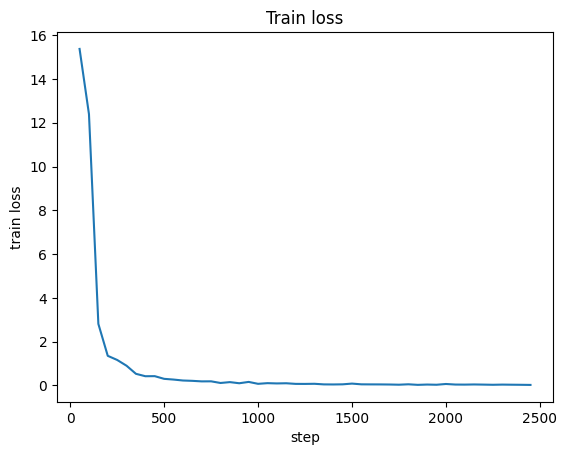

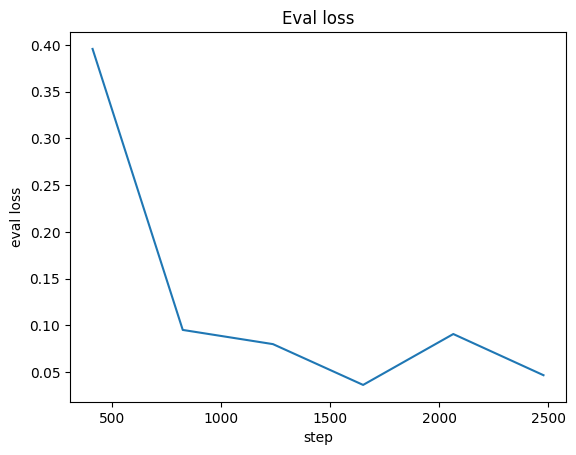

,text,label,pred_score,pred_label,abs_err
1160,Assistentin Direktor Vertrieb,Junior,5.179688,Management,4.179688
385,Sales director Germany / Head of Key Account M...,Senior,6.007812,Director,3.007812
6,Marketing Manager / Art-Director,Director,3.699219,Lead,2.300781
710,Assistentin des Vorstandsvorsitzenden,Junior,2.433594,Professional,1.433594
1390,VP Alliances and Partner Management,Management,3.705078,Lead,1.294922
745,Geschäftsfeldmanager Vertrieb/Erzeugung,Management,4.082031,Lead,0.917969
955,Marketing Manager Vertrieb/Leitung Kundenmanag...,Lead,3.113281,Senior,0.886719
463,Head of Strategic Marketing & Corporate Respon...,Lead,3.144531,Senior,0.855469
442,Chef de projet marketing digital senior,Lead,3.183594,Senior,0.816406
1000,Head of New Business & International Consultant,Lead,3.193359,Senior,0.806641


In [20]:
# In-distribution evaluation (df_seniority test split)
reg_trainer, (reg_train_pred, reg_val_pred, reg_test_pred) = run_regression(
    train_df_base,
    val_df_base,
    df_seniority_test,
    out_dir="seniority_ft_reg_base"
)

In [21]:
# Out-of-production evaluation (CV dataset)

reg_cv_pred = predict_table_reg(
    reg_trainer,
    to_hf_dataset(jobs_annotated_df.assign(labels=jobs_annotated_df["label"].map(ORD_MAP).astype(float)), label_col="labels"),
    jobs_annotated_df[["text", "label"]]
)

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

In [22]:
display(reg_cv_pred.head(30))
print("CV threshold-accuracy:", (reg_cv_pred["pred_label"] == reg_cv_pred["label"]).mean())

,text,label,pred_score,pred_label,abs_err
493,Managing Sr. Underwriting Director,Senior,6.324219,Director,3.324219
329,Vikar,Junior,4.230469,Lead,3.230469
535,EVP Strategic Partnerships,Professional,5.175781,Management,3.175781
457,"AVP, Dental Quality & Clinical Oversight",Professional,5.070312,Management,3.070312
459,Administrateur suppléant/ Membre des Commissio...,Junior,4.039062,Lead,3.039062
371,Chief Researcher,Professional,5.039062,Management,3.039062
278,Marktondersteuning,Junior,4.019531,Lead,3.019531
447,Professor of French and Francophone Studies,Professional,4.953125,Management,2.953125
138,"Writer, Editor, Publisher",Professional,4.917969,Management,2.917969
94,Partner,Management,2.150391,Professional,2.849609


CV threshold-accuracy: 0.48635634028892455


## Performance of 1. Regression without synthetic data & without oversampling

## Classification with Synthetic Data & Oversampling

## Why synthetic augmentation + classification

After establishing a stable baseline with regression, we also train a classification model.
To reduce the missing/rare-class problem (especially `Professional`), we augment the training set with synthetic samples.

Because class frequencies remain imbalanced even after augmentation, we oversample **only the training split**.
This keeps validation/test unbiased and prevents leaking distribution changes into model selection.


Gemini -> because then we also have label professional -> we use oversampling to get better representation of professional

In [23]:
train_df_aug = add_synthetic(train_df_base, "data/results/gemini_synthetic.csv")

labels: ['Director', 'Junior', 'Lead', 'Management', 'Professional', 'Senior']
val missing labels: 0
test missing labels: 0


Map:   0%|          | 0/16578 [00:00<?, ? examples/s]

Map:   0%|          | 0/1414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1415 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2151828476.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.481600,0.244998,0.920085,0.770131
2,0.287900,0.155778,0.944837,0.769821
3,0.210500,0.159620,0.950495,0.777181
4,0.201000,0.143884,0.960396,0.788600
5,0.108600,0.169921,0.955446,0.779383
6,0.112300,0.221806,0.949788,0.774731


early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled


Evaluation based on training data: {'train_loss': 0.12933620810508728, 'train_accuracy': 0.9660996501387381, 'train_f1_macro': 0.9660686607879234, 'train_runtime': 8.5775, 'train_samples_per_second': 1932.729, 'train_steps_per_second': 60.507, 'epoch': 6.0}
Evaluation based on val data:   {'val_loss': 0.1438843160867691, 'val_accuracy': 0.9603960396039604, 'val_f1_macro': 0.7885996506831079, 'val_runtime': 0.7961, 'val_samples_per_second': 1776.216, 'val_steps_per_second': 56.527, 'epoch': 6.0}
Evaluation based on test data:  {'test_loss': 0.12164306640625, 'test_accuracy': 0.9667844522968198, 'test_f1_macro': 0.7967114858144688, 'test_runtime': 0.7948, 'test_samples_per_second': 1780.359, 'test_steps_per_second': 56.619, 'epoch': 6.0}


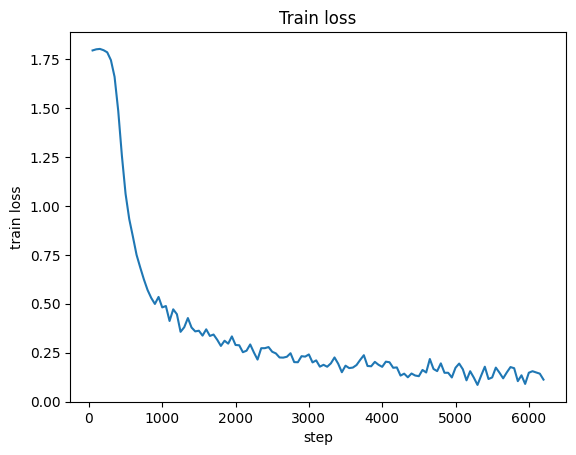

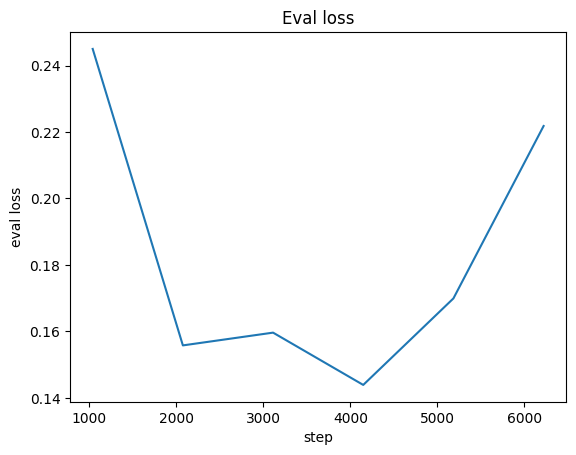

,text,label,pred_id,pred_label,correct
0,Director Business Development & Sales,Director,0,Director,True
1,Junior Manager Investor Relations & Unternehme...,Junior,1,Junior,True
2,Sales and Service Business Manager,Senior,5,Senior,True
3,VP Sales Germany,Management,3,Management,True
4,Leiter Marketing & PR,Lead,2,Lead,True
5,Marketing Communication Manager BWT France,Senior,5,Senior,True
6,Marketing Manager / Art-Director,Director,5,Senior,False
7,Director Sales and Support,Director,0,Director,True
8,Assistante commerciale et marketing,Senior,5,Senior,True
9,Marketing- und Sales-Manager,Senior,5,Senior,True


              precision    recall  f1-score   support

    Director       0.94      1.00      0.97       147
      Junior       0.90      1.00      0.95        62
        Lead       1.00      0.98      0.99       532
  Management       0.82      0.91      0.86       113
Professional       0.00      0.00      0.00         0
      Senior       0.99      0.93      0.96       560

    accuracy                           0.96      1414
   macro avg       0.77      0.80      0.79      1414
weighted avg       0.97      0.96      0.97      1414



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
cls_trainer_syn, (cls_train_pred_syn, cls_val_pred_syn, cls_test_pred_syn), (label2id_syn, id2label_syn) = run_classification(
    train_df_aug,
    val_df_base,
    df_seniority_test,
    out_dir="seniority_ft_cls_syn"
)

In [25]:
# show how often the different labels occur in train_df_aug

train_df_aug["label"].value_counts()

,count
label,
Senior,2763
Lead,2633
Management,1059
Director,914
Junior,701
Professional,415


In [26]:
# Out-of-distribution eval for classification model
cv_cls = jobs_annotated_df[["text", "label"]].copy()

# map string labels -> class ids of the SYNTHETIC-trained classifier
cv_cls["labels"] = cv_cls["label"].map(label2id_syn)

# drop rows whose labels are not in the classifier label space
cv_cls = cv_cls.dropna(subset=["labels"]).copy()
cv_cls["labels"] = cv_cls["labels"].astype(int)

cv_ds = to_hf_dataset(cv_cls, label_col="labels")

cv_pred = predict_table_cls(
    cls_trainer_syn,
    cv_ds,
    cv_cls[["text", "label"]],
    id2label_syn
)

print("CV accuracy:", cv_pred["correct"].mean())


Map:   0%|          | 0/623 [00:00<?, ? examples/s]

CV accuracy: 0.6163723916532905


In [27]:
display(cv_pred.head(30))

,text,label,pred_id,pred_label,correct
0,Prokurist,Management,3,Management,True
1,CFO,Management,3,Management,True
2,Betriebswirtin,Professional,1,Junior,False
3,Prokuristin,Management,3,Management,True
4,CFO,Management,3,Management,True
5,Solutions Architect,Professional,4,Professional,True
6,Medizintechnik Beratung,Professional,4,Professional,True
7,Director expansión de negocio.,Director,0,Director,True
8,Gerente comercial,Lead,3,Management,False
9,Administrador Unico,Professional,4,Professional,True
